In [1]:
%matplotlib inline

# TensorFlow 自动编码器(auto-encoder)

In [2]:
# -*- coding: utf-8 -*-

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange

导入MNIST数据集

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)
print(
        '训练集大小: %s;\n验证集大小: %s;\n测试集大小: %s.' % \
        (mnist.train.num_examples, mnist.validation.num_examples, mnist.test.num_examples)
)
image_size = mnist.train.images[0].shape[0]
print('输入的大小：%s' % (image_size))


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
训练集大小: 55000;
验证集大小: 5000;
测试集大小: 10000.
输入的大小：784


数据展示

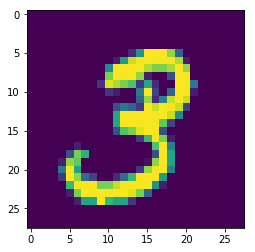

In [4]:
import numpy as np
import matplotlib.pylab as plt
from PIL import Image

# plot original
original_image = mnist.train.images[1]
plt.imshow(np.reshape(a=original_image, newshape=(28, 28)) * 255)


In [5]:
import tensorflow as tf

# hyper-parameter
training_epoch = 100
learning_rate = 1e-3
batch_size = 1000

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('placehold'):
        x = tf.placeholder(dtype=tf.float32, shape=[None, image_size], name='x')

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = tf.random_normal(shape=(batch_size, z_mean.shape[1].value))
        return z_mean + tf.exp(.5 * z_log_sigma) * epsilon


    # encoder
    encoder = tf.layers.dense(x, units=512, activation=tf.nn.relu)
    encoder_mean = tf.layers.dense(encoder, units=2)
    encoder_log_var = tf.layers.dense(encoder, units=2)
    encoder = sampling((encoder_mean, encoder_log_var))

    # decoder
    decoder = tf.layers.dense(encoder, units=512, activation=tf.nn.relu)
    decoder = tf.layers.dense(decoder, units=784, activation=tf.nn.sigmoid)
    x_ = decoder

    with tf.name_scope('loss_op'):
        tf.add_to_collection('losses', tf.reduce_sum(tf.square(x - x_), axis=-1))
        tf.add_to_collection('losses', -0.5 * tf.reduce_sum(
            1 + encoder_log_var - tf.square(encoder_mean) - tf.exp(encoder_log_var), axis=-1))
        loss_op = tf.reduce_mean(tf.add_n(tf.get_collection('losses')))
    with tf.name_scope('train_op'):
        train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op)
ret

In [6]:
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())

    # visualization
    img = np.reshape(a=original_image, newshape=(28, 28))
    blank = np.ones(shape=(28, 1))
    img = np.concatenate((img, blank), axis=-1)

    batch_episode = mnist.train.num_examples // batch_size
    for i in xrange(1, 1 + training_epoch):
        cost = 0.0
        for _ in xrange(batch_episode):
            batch_x, _ = mnist.train.next_batch(batch_size)
            feed = {x: batch_x}
            _, batch_cost = session.run([train_op, loss_op], feed_dict=feed)
            cost += batch_cost
        if i % 10 == 0:
            print('Epoch %s / %s, training cost: %s' % (i, training_epoch, cost / batch_episode))
            img_pred = x_.eval({x: original_image[None, ...]})[0]
            img = np.concatenate((img, blank, np.reshape(a=img_pred, newshape=(28, 28))), axis=-1)

    # 降维使用
    features = []
    for _ in xrange(mnist.test.num_examples // batch_size):
        batch_x, _ = mnist.test.next_batch(batch_size)
        batch_features = session.run(encoder, feed_dict={x: batch_x})
        features.append(batch_features)
    features = np.reshape(np.asarray(features), newshape=(mnist.test.num_examples, -1))


Epoch 10 / 100, training cost: 42.28003789728338
Epoch 20 / 100, training cost: 40.78637216741389
Epoch 30 / 100, training cost: 39.95652701637962
Epoch 40 / 100, training cost: 39.26598899147727
Epoch 50 / 100, training cost: 38.69729038585316
Epoch 60 / 100, training cost: 38.2019699790261
Epoch 70 / 100, training cost: 37.826492170854046
Epoch 80 / 100, training cost: 37.485478141091086
Epoch 90 / 100, training cost: 37.1927678194913
Epoch 100 / 100, training cost: 36.94785073020241


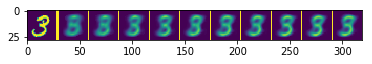

In [7]:
plt.imshow(img * 255)

auto-encoder的思想是：编码+解码<br>
这现今的很多模型设计都有着非常重要的影响。因为这一过程可以看做：从数据中获得特征（编码），从特征复原数据（解码）。目前很多sequence-t0-sequence模型都是采用的encoder+decoder模式<br>
<br>
在本例中，我们可以利用encoder的输出--若干个特征--作为MNIST数据的特征。将这些特征送到t-SNE中，降维到2维，解释MNIST数据的分布。

In [8]:
# t-SNE
# from sklearn.manifold import TSNE

# features = (np.max(features) - features) / (np.max(features) - np.min(features))  # normalization
# print('降维前，特征值的大小为：', features.shape)
# lower_val = TSNE(n_components=2).fit_transform(features)  # dimensionality reduction
# print('降维后，特征值的大小为：', lower_val.shape)


[]

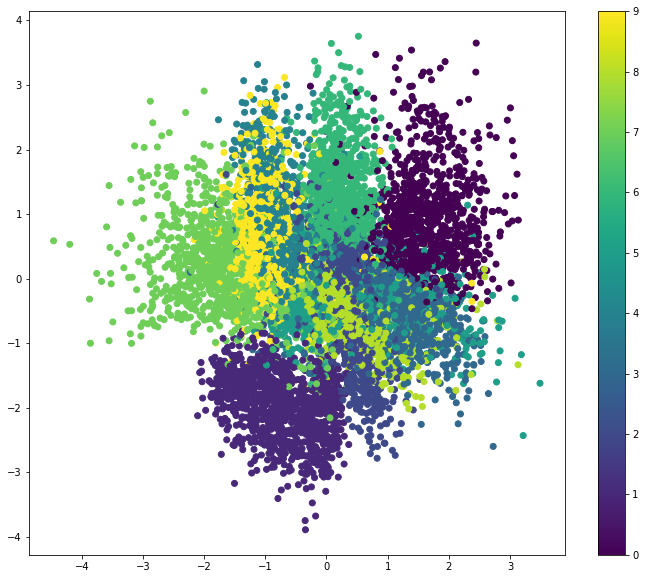

In [9]:
plt.figure(figsize=(12, 10))
plt.scatter(features[:, 0], features[:, 1], c=np.argmax(mnist.test.labels, axis=-1).tolist())
plt.colorbar()
plt.plot()


推荐资料：<br>
[Stanford UFLDL课程，Sparse Autoencoder](http://deeplearning.stanford.edu/wiki/index.php/UFLDL_Tutorial)<br>
[利用Kera框架对MNIST实现autoencoder及应用](https://blog.keras.io/building-autoencoders-in-keras.html)<br>
[Stanford UFLDL课程，PCA](http://deeplearning.stanford.edu/wiki/index.php/PCA)<br>
[快速理解t-SNE](http://www.datakit.cn/blog/2017/02/05/t_sne_full.html)<br>
[sklearn库，t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)<br>